# Correlation of CNV parameters with symptoms

The correlation between various CNV metrics and clinical scales was examined using the Spearman correlation coefficient. This method was chosen because some variables, such as the YMRS, are not normally distributed. A correlation matrix was generated using Python code to identify potential relationships between CNV metrics and clinical symptoms.


In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# set seaborn style
sns.set_style('whitegrid')

In [2]:
# Load data
df = pd.read_csv('../results/uncertain_merged_all_cnv_annotations_filtered_per_ind_with_clinical.csv')

# Remove outliers with ID S36958 and S36981
df = df[df['ID'] != 'S36958']
df = df[df['ID'] != 'S36981']

# Set inf values to 0 
inf_mask = np.isinf(df[['Avg_copy_number_DEL', 'Avg_quality_DEL']])
df.loc[inf_mask['Avg_copy_number_DEL'], 'Avg_copy_number_DEL'] = 0
df.loc[inf_mask['Avg_quality_DEL'], 'Avg_quality_DEL'] = 0

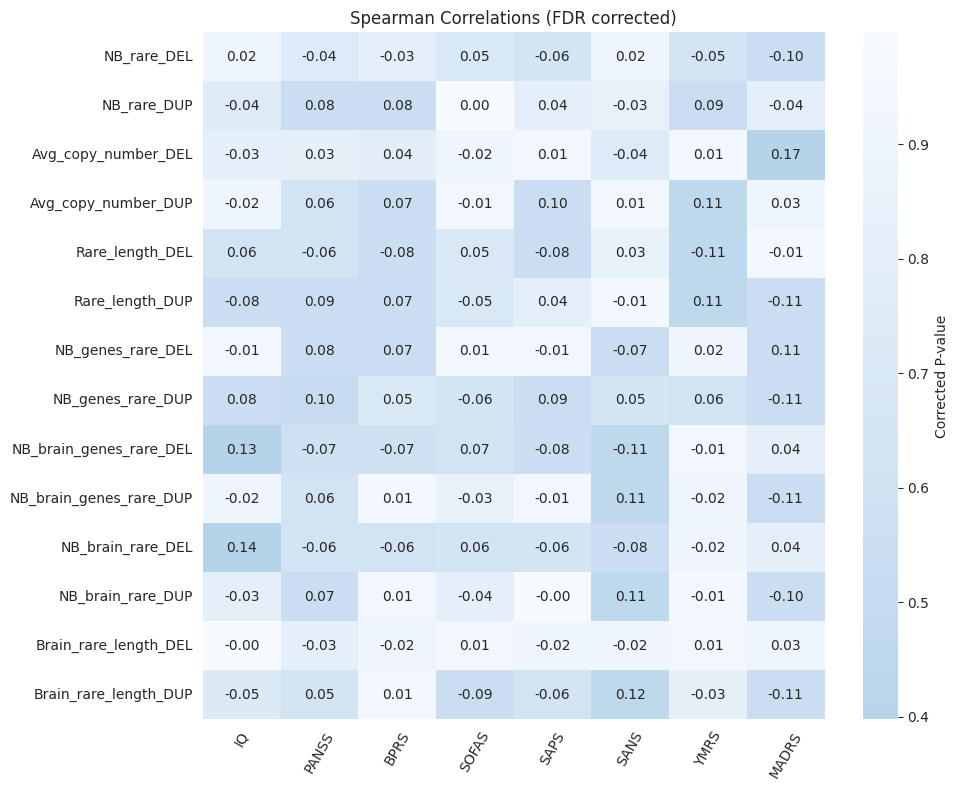

In [3]:
# Define constants
GENETICS = [
    'NB_rare_DEL', 'NB_rare_DUP', 
    'Avg_copy_number_DEL', 'Avg_copy_number_DUP', 
    'Rare_length_DEL', 'Rare_length_DUP', 
    'NB_genes_rare_DEL', 'NB_genes_rare_DUP',
    'NB_brain_genes_rare_DEL', 'NB_brain_genes_rare_DUP', 
    'NB_brain_rare_DEL', 'NB_brain_rare_DUP', 
    'Brain_rare_length_DEL', 'Brain_rare_length_DUP'
]
CLINICS = ['IQ', 'PANSS', 'BPRS', 'SOFAS', 'SAPS', 'SANS', 'YMRS', 'MADRS']

# Initialize matrices
correlation_matrix = np.zeros((len(GENETICS), len(CLINICS)))
p_values_matrix = np.zeros((len(GENETICS), len(CLINICS)))

# Calculate correlations
for i, col1 in enumerate(GENETICS):
    for j, col2 in enumerate(CLINICS):
        # Use .loc to access the specific columns
        corr, p_value = spearmanr(df[col1], df[col2], nan_policy='omit')
        correlation_matrix[i, j] = corr
        p_values_matrix[i, j] = p_value

# FDR Correction
p_values_flat = p_values_matrix.flatten()
reject, p_values_corrected, _, _ = multipletests(p_values_flat, 
                                                 method='fdr_bh')
p_values_corrected_matrix = p_values_corrected.reshape(len(GENETICS), 
                                                       len(CLINICS))

# Create DataFrames for visualization
p_values_corrected_df = pd.DataFrame(p_values_corrected_matrix, 
                                     index=GENETICS, columns=CLINICS)
correlation_df = pd.DataFrame(correlation_matrix, 
                              index=GENETICS, columns=CLINICS)

# Mask for significant values
significant_mask = p_values_corrected_df < 0.05
correlation_df_significant = correlation_df.where(significant_mask)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_corrected_df, 
            annot=correlation_df, 
            fmt=".2f", 
            cmap='Blues_r', 
            center=0, 
            cbar_kws={'label': 'Corrected P-value'}, 
            mask=np.isnan(p_values_corrected_df))
plt.xticks(rotation=60)
plt.title('Spearman Correlations (FDR corrected)')

# Highlight significant cells
for i in range(len(GENETICS)):
    for j in range(len(CLINICS)):
        if significant_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, 
                                              fill=False, 
                                              edgecolor='#155289', 
                                              lw=2))
plt.tight_layout()
plt.savefig("../graphs/correlation.png")
plt.show()


After excluding outliers, pathogenic or likely pathogenic CNVs, and Marshall’s CNVs, no significant correlation was observed. This finding aligns with the group comparison results, which also showed no significant differences. Therefore, the previously defined CNV parameters do not appear to correlate with the clinical symptoms that define phenotypes.
